<a href="https://colab.research.google.com/github/sujitpal/keras-tutorial-odsc2020/blob/master/01_02_keras_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Keras Basics

Resources for learning Keras:

* [Keras site (API + guides)](https://keras.io/)
* [tf.keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras)

The "original" Keras ([keras.io](https://keras.io/)) was designed as an easy to use API on top of low level libraries [Theano](http://deeplearning.net/software/theano/) and [Tensorflow](https://www.tensorflow.org/).

Theano support has been discontinued since 2017, and Tensorflow 2.x has adopted Keras as its default API (tf.keras). At the same time, the original Keras project has added an additional [CNTK](https://docs.microsoft.com/en-us/cognitive-toolkit/) backend.

Keras 2.3 was the last multi-backend release of Keras. As of Keras 2.4, Keras is the same as tf.keras. ([release notes](https://github.com/keras-team/keras/releases/tag/2.4.0)).

This has several advantages:
* from a Keras point of view, new features are no longer gated by the lowest common denominator, i.e., whether all backends can support the feature.
* from your point of view, because tf.keras is now __the__ official high level API of Tensorflow, learning Keras gives you the tools to work with one of the two most popular deep learning frameworks.
* Keras used to have a `keras.backend` API, now moved to `tf.keras.backend`, but you also have access to the full power of the underlying Tensorflow backend.

In this tutorial, we will look at __tf.keras__.

### Hello World -- a first Keras model

Here we will train a Fully Connected (Dense) model to predict digits from their 28x28 images from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). 

This is typically regarded as the "Hello World" of Deep Learning.

Our objective is to quickly figure out the flow in a typical Keras supervised learning pipeline.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

#### Dataset

For convenience, the MNIST dataset can be accessed through the `keras.datasets.mnist` call. It is pre-partitioned into 60k training and 10k test images and their corresponding labels.

Image below shows some samples from the MNIST dataset.

Following pre-processing steps need to be done.
* Since we are using it as input to a Fully Connected Network, we need to reshape each 2D images into a flat vector of pixels.
* We need to normalize the input space from (0, 255) pixel values into a (0, 1) range.
* Labels are in the range (0, 9), since the network we are building is a classifier that will predict one of 10 values, we need to one-hot encode the labels.

In [ ]:
mnist_dataset = keras.datasets.mnist
(Xtrain, ytrain), (Xtest, ytest) = mnist_dataset.load_data()

Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

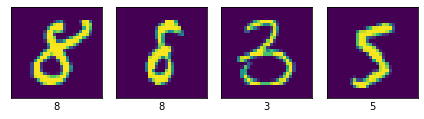

In [ ]:
image_ids = np.random.randint(0, high=len(Xtrain), size=4)
for i, image_id in enumerate(image_ids):
  plt.subplot(1, 4, i+1)
  plt.imshow(Xtrain[image_id])
  plt.xticks([])
  plt.yticks([])
  plt.xlabel("{:d}".format(ytrain[image_id]))

plt.tight_layout()
_ = plt.show()

In [ ]:
Xtrain = Xtrain.reshape(60000, -1).astype(np.float32)
Xtest = Xtest.reshape(10000, -1).astype(np.float32)

Xtrain /= 255
Xtest /= 255

In [ ]:
ytrain = keras.utils.to_categorical(ytrain, 10)
ytest = keras.utils.to_categorical(ytest, 10)

#### Model

Next we define our model. As noted before, this is a simple Fully Connected 3 layer model.

Considerations:
* Input Shape is the shape of the input. Here each of our inputs is a flat vector of size 784 (i.e. flattened 28x28 pixel image). This is specified either in an Input layer, or via the `input_shape` parameter in the first Dense layer as shown below.
* The model will output a prediction vector consisting of the number of classes it is designed to predict. For example, in our case, it needs to predict a number between 0 and 9, therefore number of output classes is 10. The output will be a vector of probabilities (for Scikit-Learn users, this is analogous to the `predict_proba()` function).
* The `activation="softmax"` in the last layer normalizes the values in the output vector by exponentiating the scores and dividing by their sum (see [Softmax Function](https://en.wikipedia.org/wiki/Softmax_function)) so that they look like probabilities (i.e., they sum to 1).


In [ ]:
model = keras.models.Sequential([
  keras.layers.Dense(128, input_shape=(784,), activation="relu", name="layer_1"),
  keras.layers.Dense(128, activation="relu", name="layer_2"),
  keras.layers.Dense(10, activation="softmax", name="layer_3")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
layer_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
layer_3 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


#### Loss Function and Optimizer

Next we need to specify the loss function, optimizer, and metrics.

* The __loss function__ is the function that gets differentiated during backpropagation, and applied back to the weights of each layer. Keras comes with a selection of pre-built loss functions for some standard applications. Some popular loss functions are as follows:
* The __optimizer__ is the thing that computes the gradient and applies it to the weights. Keras comes with some popular built-in optimizers. We describe some of these below.
* The __metric__ is the thing that gets reported at the end of each training cycle (or epoch). It is an external indicator of how good or bad the model is for the task at hand.

We will go deeper into each of these components later. For now, lets concentrate on the flow.

In [ ]:
model.compile(optimizer="SGD",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

#### Training

The single `fit()` call below represents what frameworks such as Tensorflow or Pytorch call the "training loop".

Here is what happens in the training loop.

1. a batch of training data is sent through the model and predictions $\hat y$ retrieved.
1. the loss function $L(y, \hat y)$ is computed.
1. the gradient of the loss with respect to each weight is computed and multiplied by the learning rate.
1. the weights of the model are updated
1. at the end of each epoch (i.e., after the model sees the __entirety of the training data__), report the total loss against the training data, and compute the validation loss, and training and validation accuracy. This step is optional, but Keras does it by default.
1. the process continues until the number of epochs specified by `epochs` is reached (the case here), or the loss is below some prespecified tolerance).

In addition, Keras hides many complexities from you, and protects you from bad decisions by making good decisions by default. For example, training data needs to be shuffled at the beginning of each epoch to prevent __overfitting__, but not validation or training data.

Keras offers you the ability to take over the training loop and specify it explicitly as well, as we will see later. This is only available in tf.keras via tf.GradientTape).

Keras stores the losses and metrics (both training and validation) in a `history` object, which you can examine after the training is over, as shown in the loss and accuracy plots of the model in the next cell.

In [ ]:
history = model.fit(Xtrain, ytrain, 
                    batch_size=32,
                    epochs=20,
                    validation_split=0.2)

Epoch 1/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.7289 - accuracy: 0.8111 - val_loss: 0.3376 - val_accuracy: 0.9051
Epoch 2/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3261 - accuracy: 0.9064 - val_loss: 0.2779 - val_accuracy: 0.9225
Epoch 3/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2737 - accuracy: 0.9217 - val_loss: 0.2452 - val_accuracy: 0.9295
Epoch 4/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2399 - accuracy: 0.9318 - val_loss: 0.2173 - val_accuracy: 0.9394
Epoch 5/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2135 - accuracy: 0.9394 - val_loss: 0.2036 - val_accuracy: 0.9423
Epoch 6/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1921 - accuracy: 0.9457 - val_loss: 0.1852 - val_accuracy: 0.9486
Epoch 7/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1747 - accuracy: 0.9496 - val_loss: 0.1717 - val_accuracy:

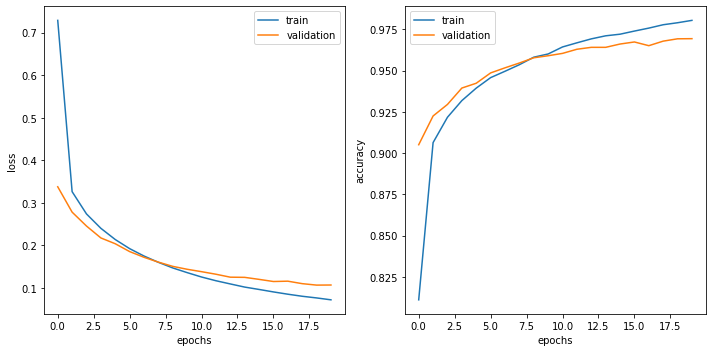

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(20), history.history["loss"], label="train")
plt.plot(np.arange(20), history.history["val_loss"], label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.plot(np.arange(20), history.history["accuracy"], label="train")
plt.plot(np.arange(20), history.history["val_accuracy"], label="validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")

plt.tight_layout()
_ = plt.show()

#### Evaluation

You can evaluate the model against the test set using the following one-liner.

In [ ]:
test_loss, test_acc = model.evaluate(Xtest, ytest)
print("test loss: {:.3f}, test accuracy: {:.3f}".format(test_loss, test_acc))

313/313 [==============================] - 0s 1ms/step - loss: 0.0988 - accuracy: 0.9691
test loss: 0.099, test accuracy: 0.969


Alternatively, you can run predictions individually against the trained model, and use your favorite libraries to do your reporting.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

ypred = model.predict(Xtest)

# convert from one-hot to prediction between 0-9
ytest_o = np.argmax(ytest, axis=1)
ypred_o = np.argmax(ypred, axis=1)

print("Accuracy: {:.3f}".format(accuracy_score(ytest_o, ypred_o)))
print("Confusion matrix")
print(confusion_matrix(ytest_o, ypred_o))

Accuracy: 0.969
Confusion matrix
[[ 968    0    1    1    0    4    3    2    1    0]
 [   0 1125    3    0    0    1    4    0    2    0]
 [   5    2 1006    3    3    0    5    5    3    0]
 [   1    1    9  977    0    9    0    8    2    3]
 [   3    0    5    0  943    0    8    2    2   19]
 [   4    1    0   13    1  859    9    0    4    1]
 [   6    3    1    0    4    6  937    0    1    0]
 [   0    8   12    3    0    1    0  997    0    7]
 [   6    0    3   14    3    8   11    8  917    4]
 [   7    6    1    9   10    2    2   10    0  962]]


### Other ways to define the model

Keras offers 3 major ways to define the same model. The way we did it in our example above is known as the __Sequential__ style, and is suitable for when the network is linear (or parts of the network are linear).

#### Functional Style

When the model resembles a graph more than a pipe, one should use the __Functional__ style. Below we define the model using the Functional style.

In [ ]:
inputs = keras.layers.Input(shape=(784,))
layer_1 = keras.layers.Dense(128, activation="relu", name="layer_1")(inputs)
layer_2 = keras.layers.Dense(128, activation="relu", name="layer_2")(layer_1)
outputs = keras.layers.Dense(10, activation="softmax", name="layer_3")(layer_2)

model_s = keras.models.Model(inputs=inputs, outputs=outputs)
model_s.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
layer_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
layer_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
layer_3 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


#### Model Subclassing Style

When you want to construct your network out of smaller network building blocks, or if you would like to define your own layer, then you would follow the __Model Subclassing__ style. This involves subclassing `keras.layers.Layer`.

Our model using the Model Subclassing style is as follows.

In [ ]:
class MnistClassifier(keras.models.Model):
  def __init__(self, hidden_dims, output_dim):
    super(MnistClassifier, self).__init__()
    self.layer_1 = keras.layers.Dense(hidden_dims[0], activation="relu", name="layer_1")
    self.layer_2 = keras.layers.Dense(hidden_dims[1], activation="relu", name="layer_2")
    self.layer_3 = keras.layers.Dense(output_dim, activation="softmax", name="layer_3")

  def call(self, inputs):
    x = self.layer_1(inputs)
    x = self.layer_2(x)
    out = self.layer_3(x)
    return out

model_sc = MnistClassifier([128, 128], 10)
model_sc.build(input_shape=(None, 784))
model_sc.summary()

Model: "mnist_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              multiple                  100480    
_________________________________________________________________
layer_2 (Dense)              multiple                  16512     
_________________________________________________________________
layer_3 (Dense)              multiple                  1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


### Activation Functions

The layer we have seen so far is `Dense`, which is really just a matrix multiplication followed by an inequality.

$$y = \sigma(WX + b)$$

Reason for the activation function $\sigma$ is to model non-linearities in the input.

Dense Layers are linear and the reason we put in the activation function between is to introduce a non-linear way to combine them. without any activations, the entire network would be linear.

* __relu__
* __sigmoid__
* __softmax__ -- softmax is slightly different in that it converts a vector into a vector of categorical probabilities.
* __softplus__
* __softsign__
* __tanh__
* __selu__
* __elu__
* __exponential__

Activations are modeled as functions (as shown below) and also as __Layers__.

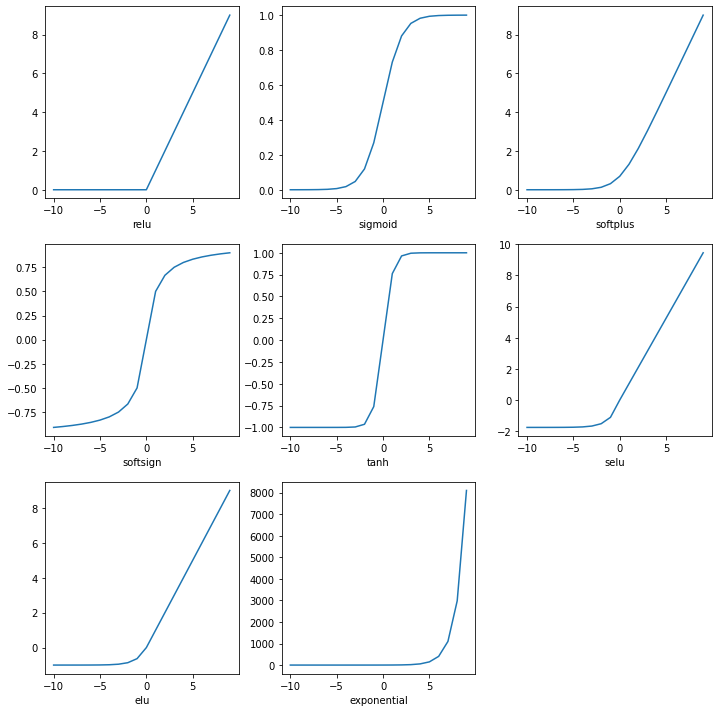

In [ ]:
x = np.arange(-10, 10, 1, dtype=np.float32)
activation_fns = [
  ("relu", keras.activations.relu),
  ("sigmoid", keras.activations.sigmoid),
  # ("softmax", keras.activations.softmax),
  ("softplus", keras.activations.softplus),
  ("softsign", keras.activations.softsign),
  ("tanh", keras.activations.tanh),
  ("selu", keras.activations.selu),
  ("elu", keras.activations.elu),
  ("exponential", keras.activations.exponential)
]

plt.figure(figsize=(10, 10))
for i, (name, activation_fn) in enumerate(activation_fns):
  plt.subplot(3, 3, i+1)
  plt.plot(x, activation_fn(x))
  plt.xlabel(name)

plt.tight_layout()
_ = plt.show()

### Other Layer Types

There are two other large architecture classes for Neural Networks, apart from the Fully Connected Networks 

* Convolutional Neural Networks (CNN) -- mostly for Computer Vision problems, but not exclusively.
  * Convolution layers
  * Pooling layers
* Recurrent Neural Networks (RNN) -- mostly for sequence data (text, audio, video, etc.)
  * LSTM layer
  * GRU layer
  * Embedding layer

We will see CNN layers in action in our next example, and our hands-on portion in this session will be around CNN as well.

### Initializers

Neural Networks learn by updating the weights within the layers. When training starts, the weight matrices are initialized to some value. This initialization is governed by the type of initializer used.

Here are the various initializers supported within Keras.

* __Random Normal__ -- initialize with numbers from a random distribution.
* __Random Uniform__ -- initialize with numbers from a uniform distribution.
* __Truncated Normal__ -- initialize with numbers from a truncated normal distribution.
* __Zeros__ -- initialize with zeros.
* __Ones__ -- initialize with ones.
* __Glorot Normal__ -- initialize with numbers from a Glorot (aka Xavier) normal distribution.
* __Glorot Uniform__ -- initialize with numbers from a Glorot (aka Xavier) uniform distribution.
* __Identity__ -- generates an identity matrix.
* __Orthogonal__ -- generates an orthogonal matrix, generated by QR decomposition of a normal matrix.
* __Constant__ -- initialize with some constant.
* __Variance Scaling__ -- initialize with scaled version of underlying distribution (truncated or untruncated normal).

### Regularizers

Neural networks are very powerful and sometimes they overfit to the data. This means that they perform very well on the training and validation set during training but very poorly on the held-out test set.

Intuitively, overfitting can be thought of as the green line that divides the red points from the blue points. A "good" fit would be the black line which divides the space smoothly but may miss a few points.


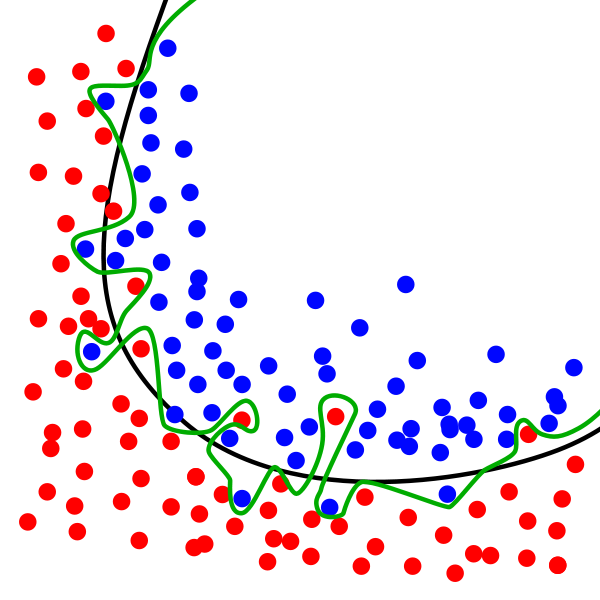

Keras provides two classes of regularizer.

* Layer weight regularizers -- __L1__, __L2__, and __L1L2__ mixed. This is achieved by a regularization term in the loss function that forces the weights on each of the individual parameters to be small.
* Regularization layers
  * __Dropout__ -- randomly turns off inputs during training. In addition to the basic Dropout layer, Keras provides [some more variants of Dropout](https://keras.io/api/layers/regularization_layers/).
  * __BatchNorm__ -- output of a BatchNorm layer is a distribution $\mathcal{N}(\mu=0, \sigma=1)$.
  * __LayerNorm__ -- output of each example is from distribution $\mathcal{N}(\mu=0, \sigma=1)$ rather than across entire batch.


### Loss Functions

Supervised Learning consists of either predicting one of N classes (classification), or predicting a continuous value (regression). Loss functions are tailored to these two high level tasks.

* __Classification Losses__
  * __BinaryCrossEntropy__ -- for binary (2 class) classifiers. Attribute label `binary_crossentropy`. Functional form `keras.losses.binary_crossentropy()`.
  * __CategoricalCrossEntropy__ -- for multi-class (more than 2 classes) classifiers when labels provided in 1-hot encoded form. Attribute label `categorical_crossentropy`. Functional form `keras.losses.categorical_crossentropy()`.
  * __SparseCategoricalCrossEntropy__ -- for multi-class classifiers when labels are provided as integers rather than 1-hot encoded form. Attribute label `sparse_categorical_crossentropy`. Functional form `keras.losses.sparse_categorical_crossentropy()`.
  * __Poisson__ -- Poisson loss is `y_pred - y_true * log(y_pred)`. Attribute label "poisson". Functional form `keras.losses.poisson()`.
* __Regression Losses__
  * __MeanSquaredError__ -- `(y_pred - y_true) ** 2`. Attribute label `mean_squared_error`, functional form `keras.losses.mean_squared_error()`.
  * __MeanAbsoluteError__ -- `|y_pred - y_true|`. Attribute label `mean_absolute_error`, functional form `keras.losses.mean_absolute_error()`.
  * [Some more Regression Losses](https://keras.io/api/losses/).

### Optimizers

A partial list optimizers supported by Keras are shown below. [Full list is here](https://keras.io/api/optimizers/).

* __SGD__ -- gradient descent optimizer with momentum. Pure SGD has trouble with ravines, the Keras SGD incorporates momentum to deal with that.
* __Adagrad__ -- automatically adapts learning rate of different parameters to frequency of update, performing large updates to less frequently updated parameters.
* __Adadelta__ -- extension of Adagrad, less aggressive learning rate decay.
* __RMSProp__ -- similar to Adadelta, seeks to address Adagrad's learning rate decay.
* __Adam__ -- uses another method to ensure adaptive learning rate for different parameters. Estimates first and second order moments and factors it into gradient. Can be viewed as RMSProp + momentum.
* __Adamax__ -- variant of Adam, sometimes better for models with embeddings.
* __Nadam__ -- ADAM + Nesterov momentum.

You can find more information in Sebastian Ruder's [An overview of gradient descent algorithms](https://arxiv.org/abs/1609.04747) paper, along with recommended values for learning rate and other parameters.

Note that Keras provides good default parameters already, so you will usually not go wrong using the Keras defaults.

### Metrics

A partial list of metrics supported by Keras are shown below. [Full list is here](https://keras.io/api/metrics/).

Metrics are like loss functions, except that metrics are for reporting external progress, while loss function is used to train the model. Any loss function can also be used as a metric.

* __Accuracy__ -- often used in classification tasks, simple and intuitive metric.
* __MeanSquaredError__ -- often used in regression tasks.
* __AUC__ -- good classification metric to use when dataset is imbalanced, computes area under ROC curve (curve of classifier performance at different operating thresholds).

Kaggle or similar competitions often have custom metrics, so it makes sense to know how to create your own metric. We will cover that when we look at Keras customizations.

### Callbacks

Callbacks are objects that can perform some work at various stages of training (before or after training, before or after each epoch, before or after each batch).

Callbacks can be attached to the training loop ([see this page](https://keras.io/api/callbacks/)) by setting the `callbacks` parameter of the `model.fit()` call.

Some important callbacks are as follows:

* __ModelCheckpoint__ -- save the model checkpoint.
* __Tensorboard__ -- write training statistics in a format readable by the Tensorboard application. Tensorboard visualizations are usually much nicer and painless than building them yourself using Matplotlib.
* __EarlyStopping__ -- stop training when a metric has stopped improving.
* __LearningRateScheduler__ -- assign a perticular learning rate schedule to the optimizer (as opposed to a constant learning rate set through the `lr` parameter).
